In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np
import read_data
import os
import shutil
from PIL import Image
import MyModels
import dataset
import random
import time
from matplotlib import pyplot as plt

# Display the results
## 1. display orginal dataset

In [28]:
dataset_train, dataset_test = dataset.get_dataset(1)
df = read_data.load_dataframe()

In [29]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
unnorm = UnNormalize(mean, std)

In [35]:
a = unnorm(dataset_train.__getitem__(17)[0])
b = unnorm(dataset_train.__getitem__(12)[0])
c = Image.open(df['image_path'].iloc[17])
d = Image.open(df['image_path'].iloc[12])

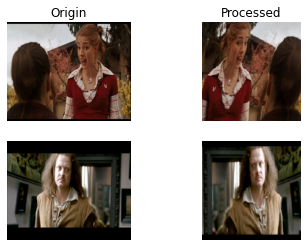

In [39]:
plt.subplot(221)
plt.imshow(c)
plt.title('Origin')
plt.axis('off')

plt.subplot(223)
plt.imshow(d)
plt.axis('off')

plt.subplot(222)
plt.title('Processed')
plt.imshow(a.permute(1, 2, 0))
plt.axis('off')

plt.subplot(224)
plt.imshow(b.permute(1, 2, 0))
plt.axis('off')

plt.show()

## 2. Display crop faces

(-0.5, 255.5, 255.5, -0.5)

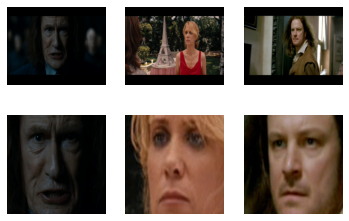

In [47]:
plt.subplot(231)
face1 = Image.open(df['image_path'].iloc[2])
plt.imshow(face1)
plt.axis('off')

plt.subplot(232)
face1 = Image.open(df['image_path'].iloc[4])
plt.imshow(face1)
plt.axis('off')

plt.subplot(233)
face1 = Image.open(df['image_path'].iloc[6])
plt.imshow(face1)
plt.axis('off')


plt.subplot(234)
face1 = Image.open(df['crop_path'].iloc[2])
plt.imshow(face1)
plt.axis('off')

plt.subplot(235)
face1 = Image.open(df['crop_path'].iloc[4])
plt.imshow(face1)
plt.axis('off')

plt.subplot(236)
face1 = Image.open(df['crop_path'].iloc[6])
plt.imshow(face1)
plt.axis('off')

In [12]:
acc = {}
for k in range(5):
    model = torch.load('models/pretrained_resnext50/Fold{}_model.pth'.format(k), map_location=torch.device('cpu'))
    model.train(False)
    _, dataset_test = dataset.get_dataset(k)
    testloader = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=2)

    class_correct = list(0 for i in range(7))
    class_total = list(0 for i in range(7))
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)

        for label, prd in zip(labels, pred):
            if label == prd:
                class_correct[label] += 1
            class_total[label] +=1

    acc[k] = [class_correct, class_total]



In [6]:
pretrain50_acc = acc
pretrain50_acc

{0: [[10, 8, 10, 10, 7, 15, 7], [20, 15, 20, 20, 20, 20, 20]],
 1: [[1, 0, 17, 13, 5, 0, 0], [20, 15, 20, 20, 20, 20, 20]],
 2: [[12, 10, 7, 11, 7, 12, 9], [20, 15, 20, 20, 20, 20, 20]],
 3: [[9, 10, 12, 11, 2, 12, 7], [20, 15, 20, 20, 20, 20, 20]],
 4: [[10, 8, 12, 10, 8, 10, 11], [20, 15, 19, 20, 20, 20, 20]]}

In [13]:
resnext_acc = acc
resnext_acc

{0: [[11, 7, 5, 9, 1, 6, 8], [20, 15, 20, 20, 20, 20, 20]],
 1: [[7, 11, 9, 6, 1, 5, 7], [20, 15, 20, 20, 20, 20, 20]],
 2: [[7, 7, 4, 13, 3, 7, 9], [20, 15, 20, 20, 20, 20, 20]],
 3: [[3, 10, 8, 6, 4, 11, 9], [20, 15, 20, 20, 20, 20, 20]],
 4: [[6, 8, 7, 12, 5, 3, 7], [20, 15, 19, 20, 20, 20, 20]]}

In [16]:
for correct, total in pretrain50_acc.values():
    ac = np.divide(np.asarray(correct), np.asarray(total))
    ov_ac = np.divide(np.sum(np.asarray(correct)), np.sum(np.asarray(total)))
    print(ov_ac)

0.4962962962962963
0.26666666666666666
0.5037037037037037
0.4666666666666667
0.5149253731343284


In [17]:
for correct, total in resnext_acc.values():
    ac = np.divide(np.asarray(correct), np.asarray(total))
    # print(ac)
    ov_ac = np.divide(np.sum(np.asarray(correct)), np.sum(np.asarray(total)))
    print(ov_ac)

[0.55       0.46666667 0.25       0.45       0.05       0.3
 0.4       ]
0.34814814814814815
[0.35       0.73333333 0.45       0.3        0.05       0.25
 0.35      ]
0.34074074074074073
[0.35       0.46666667 0.2        0.65       0.15       0.35
 0.45      ]
0.37037037037037035
[0.15       0.66666667 0.4        0.3        0.2        0.55
 0.45      ]
0.37777777777777777
[0.3        0.53333333 0.36842105 0.6        0.25       0.15
 0.35      ]
0.3582089552238806
